# Experimentacion - AGREGANDO DATA EXTERNA

## Experimentacion 1: Modelo - Ubicacion (Latitud y Longitud)

### Voy a experimentar con las caracterisiticas principales de los paises, como su ubicacion, su status, su capacidad de gasto. Todo ese tipo de atributos que lo encasillan en una etiqueta en particular. La zona donde se ubica un pais puede explicar varias cosas sobre el. Si pensamos en un pais ubicado en el hemisferio norte del mundo, es probable que demos con uno desarrollado. Mientras que si, por ejemplo, pensamos en un pais ubicado en Africa, es probable que su expectativa de vida sea menor a la media. Vamos a ver como esto se condice con los datos y el analisis de regresion.

### Importo todos los modulos, funciones y datasets que me son de ayuda para la experimentacion

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence as influence

def rmse(fitted, target):
    rmse = np.sqrt(mean_squared_error(target, fitted))
    return rmse

def adjusted_r2(p, fitted, target):
    n=len(target)
    return 1 - (1-r2_score(target, fitted)) * (n-1) / (n-p-1)

def standarized_residual_plot(predicted, actual):
    residuals = actual - predicted
    standarized_residuals = residuals/np.std(residuals)
    plt.scatter(predicted, standarized_residuals)
    plt.xlabel("Predicciones")
    plt.ylabel("Residuos standarizados")
    plt.hlines(0, xmin=min(predicted), xmax=max(predicted))
    plt.title("Residuos standarizados")
    return standarized_residuals

def ols_influence(lm):
    plt.figure(figsize=(30,30))
    sm.graphics.influence_plot(lm, alpha  = 0.05, criterion="cooks")
    plt.show()

    
def run_analysis(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    fitted = regr.predict(features)
    print(regr.summary())
    standarized_residuals = standarized_residual_plot(fitted, target)
    ols_influence(regr)
    #sm.qqplot(regr.resid)
    plt.figure()
    plt.hist(regr.resid)
    plt.show()
    return {
        'model': regr,
        'r2':r2_score(target, fitted),
        'rmse':rmse(fitted, target),
        'adjusted':adjusted_r2(p, fitted, target),
        'standarized_residuals': standarized_residuals,
        'fitted': fitted
    }

# Me da los residuos estandarizados
def residuos(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    fitted = regr.predict(features)
    standarized_residuals = standarized_residual_plot(fitted, target)
    return np.array(standarized_residuals)


# Me da la distancia de Cook de cada pais
def cooksDist(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    inf = influence(regr)
    # cooks_distance is an attribute of incluence, here C, not sure about P (p-value maybe?)
    C, P = inf.cooks_distance
    return C, P

# Me da el Leverage de cada pais
def getLeverage(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    inf = influence(regr)
    leverage = inf.hat_matrix_diag
    return leverage


df_exp = pd.read_csv("expectativa_de_vida.csv")
df_coord = pd.read_csv("average-latitude-longitude-countries.csv")

### Armo el data set con la ubicacion en el mapa de cada pais (como se realiza en el archivo 'Mapa.ipynb')

In [5]:
paises = []
nombres1 = df_exp["Country"].tolist()
nombres2 = df_coord["Country"].tolist()

from difflib import SequenceMatcher

for i in range(len(nombres1)):
    n1 = nombres1[i]
    
    conSubstringsEnComun = []
    
    for j in range(len(nombres2)):
        n2 = nombres2[j]
        seq = SequenceMatcher(None, n1, n2)
        match = seq.find_longest_match(0,len(n1),0,len(n2))
        
        """
        if ((match[2] == len(n1)) or (match[2] == len(n2))):
            r = seq.ratio()
            conSubstringsEnComun.append([r,n1,n2])
        """
        r = seq.ratio()
        
        if ((match[2] == len(n1)) or (match[2] == len(n2)) or (match[2] > 3 and r>0.6)):
            conSubstringsEnComun.append([r,n1,n2])
        
    conSubstringsEnComun.sort()
    conSubstringsEnComun.reverse()
    
    
    if (len(conSubstringsEnComun) > 0):
        paises.append([conSubstringsEnComun[0][1], conSubstringsEnComun[0][2]])
    else:
        paises.append(n1)

In [6]:
df = df_exp
latitudes = []
longitudes = []

for i in range(len(paises)):
    lat = df_coord[df_coord["Country"]==paises[i][1]]["Latitude"].values
    long = df_coord[df_coord["Country"]==paises[i][1]]["Longitude"].values
    if len(lat) > 0:
        lat = lat[0]
        long = long[0]
    else:
        lat = 0
        long = 0
    latitudes.append(lat)
    longitudes.append(long)

df["Latitude"] = latitudes
df["Longitude"] = longitudes

In [11]:
df['Status_Float'] = df['Status'].apply(lambda x: 0 if x=='Developing' else 1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       183 non-null    int64  
 1   Country                          183 non-null    object 
 2   Life expectancy                  183 non-null    float64
 3   Adult Mortality                  183 non-null    float64
 4   infant deaths                    183 non-null    float64
 5   Alcohol                          182 non-null    float64
 6   percentage expenditure           183 non-null    float64
 7   Hepatitis B                      174 non-null    float64
 8   Measles                          183 non-null    float64
 9   BMI                              181 non-null    float64
 10  under-five deaths                183 non-null    float64
 11  Polio                            183 non-null    float64
 12  Total expenditure     

### Ahora agrego la zona donde se encuentra cada Estado

In [13]:
df.corr()['Life expectancy']

Unnamed: 0                        -0.017423
Life expectancy                    1.000000
Adult Mortality                   -0.896441
infant deaths                     -0.199914
Alcohol                            0.461720
percentage expenditure             0.524320
Hepatitis B                        0.429536
Measles                           -0.201076
BMI                                0.723824
under-five deaths                 -0.225785
Polio                              0.679231
Total expenditure                  0.290713
Diphtheria                         0.672322
HIV/AIDS                          -0.587153
GDP                                0.611808
Population                        -0.039915
thinness  1-19 years              -0.523989
thinness 5-9 years                -0.515970
Income composition of resources    0.817545
Schooling                          0.794457
Latitude                           0.471175
Longitude                         -0.098699
Status_Float                    

### Sabiendo las coordenadas de cada pais, analizamos como estas infieren en su expectativa de vida

VIF for Latitude 1.0437650861009335
VIF for Longitude 1.0437650861009335
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     27.76
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           3.12e-11
Time:                        20:14:46   Log-Likelihood:                -640.41
No. Observations:                 183   AIC:                             1287.
Df Residuals:                     180   BIC:                             1296.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

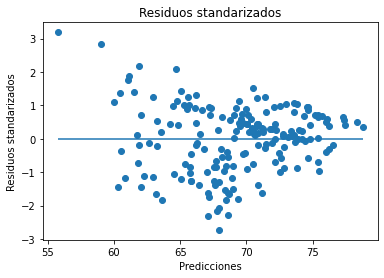

<Figure size 2160x2160 with 0 Axes>

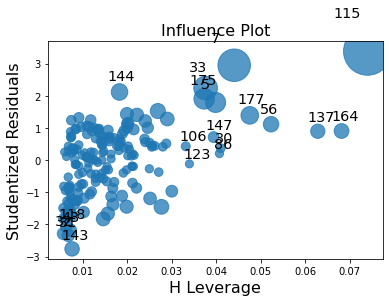

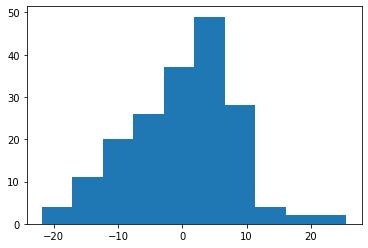

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f90d8385dc0>,
 'r2': 0.235703390469284,
 'rmse': 8.009178403974595,
 'adjusted': 0.22721120591894284,
 'standarized_residuals': 0     -1.616090
 1      0.224940
 2      0.293656
 3     -1.821969
 4      0.586737
          ...   
 178    0.575885
 179    0.927827
 180   -0.533636
 181   -1.130594
 182   -1.443459
 Name: Life expectancy, Length: 183, dtype: float64,
 'fitted': array([71.13729937, 73.35466208, 71.26680619, 63.61122223, 70.35697096,
        61.07265077, 72.75172118, 59.03844238, 74.62261725, 72.80098217,
        71.91039014, 70.10211862, 69.07362415, 69.61034711, 75.41125185,
        75.4185628 , 70.84662565, 67.90146854, 69.70428844, 64.19352518,
        73.93606538, 61.78412342, 65.30352807, 65.09828374, 73.63577584,
        68.61199915, 65.06118776, 69.52968173, 66.812905  , 67.09846112,
        78.75751197, 67.12972724, 68.62408949, 61.92071568, 70.82992439,
        68.14565052, 63.23851795, 

In [15]:
run_analysis(['Latitude', 'Longitude'], df)

### Por lo pronto no hay un valor considerable en el ajuste. Y si anadimos su status? Nos proveera mas informacion esto?

VIF for Latitude 1.4933713728428735
VIF for Longitude 1.0452640220137241
VIF for Status_Float 1.4617368617754973
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     31.73
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           1.70e-16
Time:                        20:17:48   Log-Likelihood:                -625.99
No. Observations:                 183   AIC:                             1260.
Df Residuals:                     179   BIC:                             1273.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

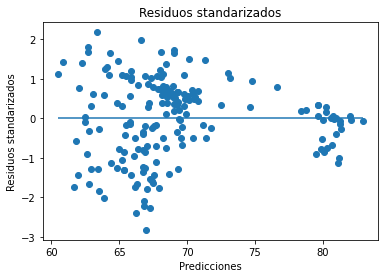

<Figure size 2160x2160 with 0 Axes>

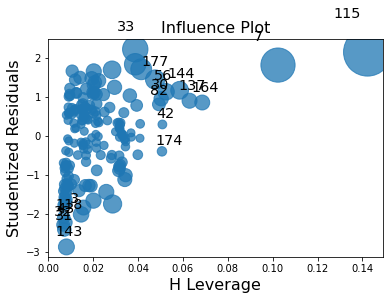

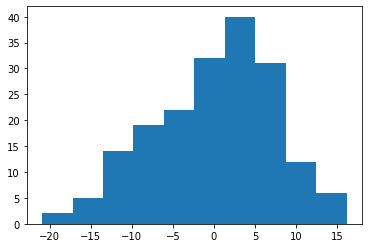

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f90607d7310>,
 'r2': 0.34717406193386036,
 'rmse': 7.402112849371557,
 'adjusted': 0.33623284509476303,
 'standarized_residuals': 0     -1.414891
 1      0.638174
 2      0.605315
 3     -2.011736
 4      0.827641
          ...   
 178    0.741943
 179    1.203079
 180   -0.391527
 181   -1.282966
 182   -1.662143
 Name: Life expectancy, Length: 183, dtype: float64,
 'fitted': array([68.66693032, 70.4324145 , 69.13814333, 63.90984861, 68.92995568,
        62.71951711, 69.873214  , 69.03315839, 80.2225125 , 69.89073814,
        70.05938466, 68.0625481 , 67.12847397, 68.41535574, 71.76152435,
        80.81394828, 69.42530048, 66.88671798, 67.54816254, 64.81790753,
        70.83457892, 62.65088771, 65.500039  , 64.31051   , 79.48859506,
        67.38939731, 64.81058642, 68.14099655, 65.51992107, 66.28794408,
        74.76739731, 66.25310539, 67.26730472, 63.33144722, 68.21287466,
        67.51075632, 63.50034559

In [17]:
run_analysis(['Latitude', 'Longitude', 'Status_Float'], df)

### Vemos como el R2 va en aumento. Finalizemos agregando el gasto por pais, esto seguro nos dara un mayor contexto. Mezclando no solo la geografia de los paises sino tambien las finanzas, estos atributos van de la mano con el 'Status' de un pais.

In [19]:
df[f'Normalizado_Gasto'] = (df['percentage expenditure']-np.mean(df['percentage expenditure']))/np.std(df['percentage expenditure'])

VIF for Latitude 1.4944442091268018
VIF for Longitude 1.0564488736796371
VIF for Status_Float 1.961142487687494
VIF for Normalizado_Gasto 1.4653418649377157
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     29.95
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           4.70e-19
Time:                        20:28:59   Log-Likelihood:                -617.91
No. Observations:                 183   AIC:                             1246.
Df Residuals:                     178   BIC:                             1262.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t

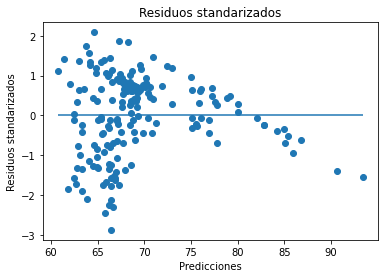

<Figure size 2160x2160 with 0 Axes>

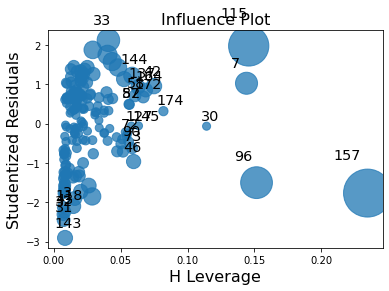

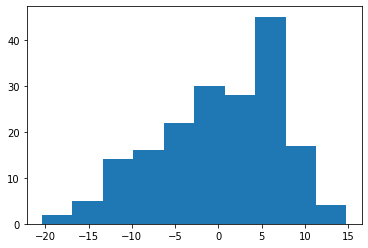

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f90d837c070>,
 'r2': 0.4023144353766791,
 'rmse': 7.082610917841364,
 'adjusted': 0.388883299093009,
 'standarized_residuals': 0     -1.373868
 1      0.753536
 2      0.686003
 3     -2.094282
 4      0.707836
          ...   
 178    0.864664
 179    1.331543
 180   -0.326664
 181   -1.336192
 182   -1.723867
 Name: Life expectancy, Length: 183, dtype: float64,
 'fitted': array([67.9243198 , 69.81924889, 68.76005532, 63.85173145, 70.04292144,
        64.09787649, 69.18914533, 74.97404045, 84.25333921, 69.20327222,
        69.1940784 , 68.45163447, 66.53445652, 68.44471609, 71.24796277,
        80.06914982, 69.31947536, 66.40145979, 67.09776732, 64.52649238,
        70.21945787, 63.16043245, 65.85269883, 66.32676579, 75.07930885,
        66.86627182, 64.48329183, 67.80362013, 65.09678951, 65.86329034,
        82.12283628, 65.81952354, 66.70654306, 64.6513826 , 67.56500677,
        67.88626452, 63.36886486, 6

In [ ]:
run_analysis(['Latitude', 'Longitude', 'Status_Float', 'Normalizado_Gasto'], df)

## Experimentacion 2: Modelo - Convictos